In [4]:
import pandas as pd

# Load the CSV file
questions_df = pd.read_csv("final_final_questions.csv")

# Display unique categories in the 'category' column
unique_categories = questions_df['Category'].unique()
print(unique_categories)

['Legal and Compliance' 'Financial' 'Technical' 'Auditability'
 'Reputational and Strategic' 'Cybersecurity']


In [ ]:
# Model Loading: support llama-cpp-python and Hugging Face Transformers (PyTorch)
try:
    from llama_cpp import Llama
except ImportError:
    Llama = None

model = None
tokenizer = None
if Llama:
    # Load a local LLaMA model using llama-cpp
    model_path = "path/to/your/llama_model.bin"  # replace with actual model file
    model = Llama(model_path=model_path, n_ctx=2048, n_threads=8)
    # The Llama model can be called as a function to generate text (shown later)
else:
    # Fallback to Hugging Face Transformers if llama_cpp is not available
    from transformers import AutoModelForCausalLM, AutoTokenizer
    model_name = "gpt2"  # placeholder for an actual large model, e.g. "bertin-project/bertin-gpt-j-6B"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model.eval()  # set to evaluation mode
    # Note: For a transformers model, we'll use tokenizer and model.generate for inference.


In [ ]:
def craft_prompt(question: str, category: str) -> str:
    """Dynamically craft the multi-expert prompt based on question category."""
    # Category-specific focus instructions
    category_focus = {
        "Legal": "Pay special attention to legal compliance, regulatory frameworks, and potential liabilities.",
        "Financial": "Focus on financial implications, investment risks, and performance metrics.",
        "Technical": "Focus on technical aspects such as blockchain protocol security, smart contract risks, and technological vulnerabilities.",
        "Compliance": "Consider compliance with relevant laws, KYC/AML requirements, and internal policy adherence.",
        "Blockchain": "Focus on blockchain-specific issues like network security, decentralization, and consensus mechanism risks.",
        "Operational": "Focus on operational factors such as team experience, process reliability, and asset security."
    }
    focus_instruction = category_focus.get(category, "")
    # Construct the prompt with multiple expert personas and required JSON format
    prompt = f"""
You are a panel of experts performing due diligence on a crypto fund. The question category is {category}. {focus_instruction}

Question: "{question}"

Please have each of the following experts provide an evaluation with scores and reasoning:
- Compliance Officer: Discuss regulatory and compliance issues. Provide a Regulatory Risk Score and Severity Score, and note any data accessibility concerns.
- Blockchain Auditor: Analyze technical and blockchain aspects. Provide a Blockchain-Specific Risk Score and Severity Score, noting any technical vulnerabilities.
- Hedge Fund Manager: Consider financial and strategic implications. Provide a Severity Score and a Contribution Score (the importance of this question to overall due diligence).
- Regulatory Attorney: Assess legal/regulatory issues in depth. Provide a Regulatory Risk Score and a Data Accessibility Score (how accessible or transparent the needed information is).

After the individual evaluations, aggregate the insights into a final assessment with overall scores:
- Severity (0-10)
- Data Accessibility (0-10)
- Contribution (0-10)
- Regulatory Risk (0-10)
- Blockchain Risk (0-10)

Finally, provide a combined risk score (0-10) summarizing the overall risk level of the question, and a brief rationale.

Output format (JSON only, no extra text):
{{
  "category": "{category}",
  "expert_evaluations": {{
    "Compliance Officer": {{"severity": <int>, "regulatory_risk": <int>, "data_accessibility": <int>, "notes": "<text>"}},
    "Blockchain Auditor": {{"severity": <int>, "blockchain_risk": <int>, "notes": "<text>"}},
    "Hedge Fund Manager": {{"severity": <int>, "contribution": <int>, "notes": "<text>"}},
    "Regulatory Attorney": {{"severity": <int>, "regulatory_risk": <int>, "data_accessibility": <int>, "notes": "<text>"}}
  }},
  "aggregated_scores": {{
    "severity": <int>,
    "data_accessibility": <int>,
    "contribution": <int>,
    "regulatory_risk": <int>,
    "blockchain_risk": <int>
  }},
  "combined_risk_score": <float>,
  "combined_risk_level": "<text>",
  "notes": "<summary or recommendation>"
}}
""".strip()
    return prompt


In [ ]:
import math, json

def compute_combined_score(scores: dict, weights: dict = None, method: str = "geometric") -> float:
    """
    Compute an overall risk score from individual dimension scores using either a weighted geometric mean or weighted arithmetic mean.
    """
    # If no weights provided, default to equal weighting
    if weights is None:
        weights = {k: 1 for k in scores}
    total_weight = sum(weights.values())
    if method == "geometric":
        product = 1.0
        for k, v in scores.items():
            w = weights.get(k, 1)
            # For geometric mean: multiply factors raised to (w/total_weight)
            product *= (max(v, 0) + 1e-9) ** (w / total_weight)
        combined_score = product  # nth root taken via exponents above
    else:
        # Weighted arithmetic mean
        combined_score = sum(weights.get(k, 1) * v for k, v in scores.items()) / total_weight
    return combined_score

# Example: parse model output and compute a refined combined score
model_output_json = '{"category": "Legal", "expert_evaluations": { ... }, "aggregated_scores": {"severity": 7, "data_accessibility": 6, "contribution": 8, "regulatory_risk": 9, "blockchain_risk": 5}, "combined_risk_score": 0, "combined_risk_level": "", "notes": ""}'
result = json.loads(model_output_json)
scores = result["aggregated_scores"]
# Define custom weights (if any)
weights = {"severity": 1, "data_accessibility": 0.5, "contribution": 0.5, "regulatory_risk": 2, "blockchain_risk": 2}
# Compute combined risk using geometric method
combined = compute_combined_score(scores, weights, method="geometric")
result["combined_risk_score"] = round(combined, 2)
# Assign a qualitative level based on thresholds
if combined <= 3:
    result["combined_risk_level"] = "Low"
elif combined <= 6:
    result["combined_risk_level"] = "Moderate"
else:
    result["combined_risk_level"] = "High"


In [ ]:
import json

# Assume 'model' (the loaded LLM) and 'tokenizer' (if using transformers) are already initialized.
# Also assume craft_prompt is defined as above.
question = "What safeguards are in place to protect investor funds from hacking or theft?"
category = "Operational"
prompt = craft_prompt(question, category)

# Generate model output (LLM inference)
if callable(model):
    # If using llama-cpp or similar (model is callable)
    result = model(prompt, max_tokens=512, stop=["}"])  # stopping at '}' to end at end of JSON
    output_text = result["choices"][0]["text"]
else:
    # If using a HuggingFace transformers model
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(inputs, max_new_tokens=512, pad_token_id=tokenizer.eos_token_id)
    output_text = tokenizer.decode(outputs[0][inputs.shape[-1]:], skip_special_tokens=True)

# Parse the JSON string output from the model
evaluation = json.loads(output_text)


In [ ]:
import time

def run_model_inference(model_obj, prompt: str) -> str:
    # Unified inference call for either model type
    if model_obj is None:
        return ""  # handle missing model gracefully
    if callable(model_obj):
        result = model_obj(prompt, max_tokens=512, stop=["}"])
        return result["choices"][0]["text"]
    else:
        inputs = tokenizer.encode(prompt, return_tensors='pt')
        outputs = model_obj.generate(inputs, max_new_tokens=512, pad_token_id=tokenizer.eos_token_id)
        return tokenizer.decode(outputs[0][inputs.shape[-1]:], skip_special_tokens=True)

# Define a set of questions to benchmark
questions = [
    ("Does the fund comply with international anti-money laundering (AML) laws?", "Compliance"),
    ("What is the contingency plan if a major blockchain the fund relies on experiences a failure or fork?", "Blockchain")
]

# Define models to compare (assuming `model` is already loaded; a second model could be added)
models_to_test = {
    "LLaMA-13B": model,
    "GPT-4 API": None  # Placeholder for a GPT-4 model/client if available
}

benchmark_results = {}
for model_name, model_obj in models_to_test.items():
    evaluations = []
    for q, cat in questions:
        prompt = craft_prompt(q, cat)
        start_time = time.time()
        output = run_model_inference(model_obj, prompt)
        elapsed = time.time() - start_time
        if not output:
            continue  # skip if model is None
        eval_json = json.loads(output)
        eval_json["latency"] = round(elapsed, 2)
        evaluations.append(eval_json)
    if evaluations:
        benchmark_results[model_name] = evaluations

# Output a summary of results
for model_name, evals in benchmark_results.items():
    avg_latency = sum(e["latency"] for e in evals) / len(evals)
    print(f"{model_name} average latency: {avg_latency:.2f}s")
    for e in evals:
        print(f"  - [{e['category']}] combined_risk_score = {e.get('combined_risk_score')}, latency = {e['latency']}s")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example aggregated scores from the evaluation (for one question)
scores = {"Severity": 7, "Data Accessibility": 6, "Contribution": 8, "Regulatory Risk": 9, "Blockchain Risk": 5}
labels = list(scores.keys())
values = list(scores.values())

# Prepare angles for radar chart
num_vars = len(labels)
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]   # close the circle
values += values[:1]

# Plot radar chart
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})
ax.plot(angles, values, marker='o', color='orange')
ax.fill(angles, values, color='orange', alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks(range(0, 11, 5))
ax.set_ylim(0, 10)
ax.set_title("Risk Profile Radar Chart")
plt.show()


In [7]:
questions = questions_df[['Question', 'Category']]

In [8]:
questions

,Question,Category
0,In which jurisdictions is the digital asset/cr...,Legal and Compliance
1,What are the applicable laws and regulations i...,Legal and Compliance
2,Has the project obtained all necessary license...,Legal and Compliance
3,What is the legal structure of the entity behi...,Legal and Compliance
4,What are the legal rights and obligations of t...,Legal and Compliance
...,...,...
546,What are the biggest risks currently facing th...,Auditability
547,How frequently is regulatory reporting evaluat...,Legal and Compliance
548,How does the project benchmark its governance ...,Cybersecurity
549,How frequently is on-chain traceability evalua...,Auditability


In [9]:
first_100_questions = questions.head(100)
first_100_questions

,Question,Category
0,In which jurisdictions is the digital asset/cr...,Legal and Compliance
1,What are the applicable laws and regulations i...,Legal and Compliance
2,Has the project obtained all necessary license...,Legal and Compliance
3,What is the legal structure of the entity behi...,Legal and Compliance
4,What are the legal rights and obligations of t...,Legal and Compliance
...,...,...
95,What is the projects treasury management strat...,Financial
96,Which accounting standards are being used?,Financial
97,"Who are the auditors, and what is their reputa...",Financial
98,Are there regular proof of reserve audits?,Financial


In [10]:
import os
import json
import time
import concurrent.futures
from typing import Dict, List, Tuple
import requests
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# ========== Configuration ==========
CATEGORY_CONFIG = {
    'Legal and Compliance': {
        'experts': ['Compliance Officer', 'Regulatory Attorney', 'Audit Specialist'],
    },
    'Financial': {
        'experts': ['Hedge Fund Manager', 'Financial Auditor', 'Risk Analyst'],
    },
    'Technical': {
        'experts': ['Blockchain Architect', 'Smart Contract Auditor', 'Network Security'],
    },
    'Auditability': {
        'experts': ['Forensic Auditor', 'Data Integrity Specialist', 'Compliance Manager'],
    },
    'Reputational and Strategic': {
        'experts': ['Brand Strategist', 'Crisis Manager', 'Market Analyst'],
    },
    'Cybersecurity': {
        'experts': ['Security Architect', 'Penetration Tester', 'Incident Responder'],
    }
}

WEIGHTS = {
    'severity': 0.4,
    'data_accessibility': -0.2,
    'category_risk': 0.3,
    'strategic_impact': 0.5
}

# ========== Model Manager (Ollama API) ==========
class ModelManager:
    def __init__(self, model_name="llama3", server_url="http://localhost:11434"):
        self.model_name = model_name
        self.server_url = server_url

    def generate(self, prompt: str) -> str:
        url = f"{self.server_url}/api/generate"
        payload = {
            "model": self.model_name,
            "prompt": prompt,
            "stream": False
        }
        response = requests.post(url, json=payload)
        response.raise_for_status()
        return response.json()['response']

# ========== JSON Fixer ==========
def fix_json_string(text: str) -> str:
    """Fix common minor JSON mistakes in LLM outputs."""
    text = text.strip()
    first_brace = text.find('{')
    last_brace = text.rfind('}')
    if first_brace != -1 and last_brace != -1:
        text = text[first_brace:last_brace + 1]
    text = re.sub(r',\s*([\]}])', r'\1', text)
    text = text.replace("'", '"')
    return text

# ========== Prompt Engineering ==========
def craft_category_prompt(question: str, category: str) -> str:
    config = CATEGORY_CONFIG[category]
    experts = "\n".join([
        f"- {expert}: Evaluate based on your expertise in {expert.split()[-1].lower()}."
        for expert in config['experts']
    ])
    experts_json = ", ".join([
        f'"{expert}": {{"score": 0, "rationale": ""}}'
        for expert in config['experts']
    ])

    return f"""
You are a panel of independent crypto risk assessors.

**Task**: Carefully analyze the following question inside the {category} domain.

**Question**: "{question}"

**Roles**:
{experts}

**Requirements**:
- Provide each expert's score (1-10) and a 1-2 sentence rationale.
- Fill the scoring fields numerically only (no text inside numbers).
- Output strictly in valid JSON.

**JSON Format**:
{{
  "analysis": {{
    "experts": {{
      {experts_json}
    }},
    "aggregates": {{
      "severity": 0,
      "data_accessibility": 0,
      "category_risk": 0,
      "strategic_impact": 0
    }},
    "risk_profile": "Low"
  }}
}}

If unsure, estimate conservatively. Respond ONLY with JSON.
"""

# ========== Flattening ==========
def flatten_analysis_output(analysis: Dict, category: str) -> Dict:
    flat = {}
    experts = CATEGORY_CONFIG[category]['experts']

    for expert in experts:
        exp_data = analysis['experts'].get(expert, {})
        flat[f"expert_{expert.replace(' ', '_').lower()}_score"] = exp_data.get('score')
        flat[f"expert_{expert.replace(' ', '_').lower()}_rationale"] = exp_data.get('rationale')

    aggregates = analysis.get('aggregates', {})
    for key, value in aggregates.items():
        flat[f"aggregate_{key}"] = value

    flat['risk_profile'] = analysis.get('risk_profile', 'Unknown')
    return flat

# ========== Analyzer ==========
class DueDiligenceAnalyzer:
    def __init__(self, model_manager: ModelManager):
        self.mm = model_manager

    def analyze_question(self, question: str, category: str) -> Dict:
        prompt = craft_category_prompt(question, category)
        raw_output = self.mm.generate(prompt)

        try:
            fixed_output = fix_json_string(raw_output)
            result = json.loads(fixed_output)
            scores = result['analysis']['aggregates']
            risk_score = sum(
                scores[k] * WEIGHTS[k]
                for k in WEIGHTS
            ) / sum(abs(w) for w in WEIGHTS.values())

            flat = flatten_analysis_output(result['analysis'], category)

            return {
                'question': question,
                'category': category,
                **flat,
                'risk_score': round(risk_score, 2)
            }
        except Exception as e:
            return {
                'question': question,
                'category': category,
                'error': str(e),
                'raw_output': raw_output
            }

# ========== Parallel Benchmark ==========
class ParallelBenchmarkSuite:
    def __init__(self, analyzer: DueDiligenceAnalyzer, max_workers: int = 4):
        self.analyzer = analyzer
        self.max_workers = max_workers

    def _process_single(self, q_cat: Tuple[str, str]) -> Dict:
        q, cat = q_cat
        return self.analyzer.analyze_question(q, cat)

    def run_benchmark(self, questions: List[Tuple[str, str]]) -> pd.DataFrame:
        results = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = [executor.submit(self._process_single, q_cat) for q_cat in questions]
            for f in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Analyzing Questions"):
                results.append(f.result())
        return pd.DataFrame(results)

# ========== Main ==========
if __name__ == "__main__":
    mm = ModelManager(model_name="llama3")
    analyzer = DueDiligenceAnalyzer(mm)
    benchmark = ParallelBenchmarkSuite(analyzer, max_workers=4)

    #df_questions = pd.read_csv('final_final_questions.csv')  # Must have 'Question' and 'Category'
    question_list = list(zip(first_100_questions['Question'], first_100_questions['Category']))

    df_results = benchmark.run_benchmark(question_list)

    # Save final results
    df_results.to_csv('final_due_diligence_output.csv', index=False)
    print("\n✅ Results saved to 'final_due_diligence_output.csv'!")

    # Optional: visualize (if needed)
    try:
        benchmark.visualize_results(df_results)
    except Exception:
        pass  # No need if errors exist


Analyzing Questions: 100%|██████████| 100/100 [22:22<00:00, 13.43s/it]


✅ Results saved to 'final_due_diligence_output.csv'!


In [11]:
df_results

,question,category,error,raw_output,expert_compliance_officer_score,expert_compliance_officer_rationale,expert_regulatory_attorney_score,expert_regulatory_attorney_rationale,expert_audit_specialist_score,expert_audit_specialist_rationale,...,expert_smart_contract_auditor_score,expert_smart_contract_auditor_rationale,expert_network_security_score,expert_network_security_rationale,expert_brand_strategist_score,expert_brand_strategist_rationale,expert_crisis_manager_score,expert_crisis_manager_rationale,expert_market_analyst_score,expert_market_analyst_rationale
0,In which jurisdictions is the digital asset/cr...,Legal and Compliance,"Expecting ',' delimiter: line 15 column 2 (cha...","{\n ""analysis"": {\n ""experts"": {\n ""C...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,What is the legal structure of the entity behi...,Legal and Compliance,"Expecting ',' delimiter: line 15 column 2 (cha...","{\n ""analysis"": {\n ""experts"": {\n ""C...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Has the project obtained all necessary license...,Legal and Compliance,NaN,NaN,8.0,,9.0,,7.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,What are the applicable laws and regulations i...,Legal and Compliance,NaN,NaN,7.0,,9.0,,6.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,What are the legal rights and obligations of t...,Legal and Compliance,NaN,NaN,8.0,,7.0,,6.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,What is the projects treasury management strat...,Financial,"Expecting ',' delimiter: line 15 column 2 (cha...","{\n ""analysis"": {\n ""experts"": {\n ""H...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,Which accounting standards are being used?,Financial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,"Who are the auditors, and what is their reputa...",Financial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,Are there regular proof of reserve audits?,Financial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# List all columns in the notebook
all_columns = set()
for df in [df_results]:
    all_columns.update(df.columns)

print(all_columns)

{'expert_financial_auditor_score', 'expert_data_integrity_specialist_rationale', 'expert_brand_strategist_score', 'aggregate_category_risk', 'expert_compliance_manager_rationale', 'error', 'question', 'expert_network_security_rationale', 'expert_network_security_score', 'expert_hedge_fund_manager_score', 'expert_blockchain_architect_rationale', 'aggregate_data_accessibility', 'expert_crisis_manager_score', 'expert_regulatory_attorney_score', 'expert_forensic_auditor_rationale', 'raw_output', 'expert_financial_auditor_rationale', 'expert_compliance_manager_score', 'expert_compliance_officer_score', 'expert_market_analyst_score', 'expert_hedge_fund_manager_rationale', 'expert_compliance_officer_rationale', 'risk_score', 'aggregate_severity', 'category', 'expert_forensic_auditor_score', 'expert_smart_contract_auditor_rationale', 'risk_profile', 'expert_data_integrity_specialist_score', 'expert_regulatory_attorney_rationale', 'expert_brand_strategist_rationale', 'expert_risk_analyst_ration

In [13]:
df_results[['question', 'risk_score', 'aggregate_severity', 'risk_profile']]

,question,risk_score,aggregate_severity,risk_profile
0,In which jurisdictions is the digital asset/cr...,NaN,NaN,NaN
1,What is the legal structure of the entity behi...,NaN,NaN,NaN
2,Has the project obtained all necessary license...,0.00,0.0,Low
3,What are the applicable laws and regulations i...,3.57,8.0,Medium
4,What are the legal rights and obligations of t...,3.21,7.0,Medium
...,...,...,...,...
95,What is the projects treasury management strat...,NaN,NaN,NaN
96,Which accounting standards are being used?,3.36,5.0,Medium
97,"Who are the auditors, and what is their reputa...",0.00,0.0,Low
98,Are there regular proof of reserve audits?,0.00,0.0,Low


In [17]:
import os
import json
import time
import concurrent.futures
from typing import Dict, List, Tuple
import requests
import pandas as pd
from tqdm import tqdm
import re

# ========== Configuration ==========
CATEGORY_CONFIG = {
    'Legal and Compliance': {},
    'Financial': {},
    'Technical': {},
    'Auditability': {},
    'Reputational and Strategic': {},
    'Cybersecurity': {}
}

WEIGHTS = {
    'severity': 0.4,
    'data_accessibility': -0.2,
    'category_risk': 0.3,
    'strategic_impact': 0.5
}

# ========== Model Manager (Ollama API) ==========
class ModelManager:
    def __init__(self, model_name="llama3", server_url="http://localhost:11434"):
        self.model_name = model_name
        self.server_url = server_url

    def generate(self, prompt: str) -> str:
        url = f"{self.server_url}/api/generate"
        payload = {"model": self.model_name, "prompt": prompt, "stream": False}
        response = requests.post(url, json=payload)
        response.raise_for_status()
        return response.json()['response']

# ========== JSON Fixer ==========
def fix_json_string(text: str) -> str:
    text = text.strip()
    first_brace = text.find('{')
    last_brace = text.rfind('}')
    if first_brace != -1 and last_brace != -1:
        text = text[first_brace:last_brace + 1]
    text = re.sub(r',\s*([\]}])', r'\1', text)
    text = text.replace("'", '"')
    return text

# ========== Prompt Engineering ==========
def craft_category_prompt(question: str, category: str) -> str:
    return f"""
You are a crypto due diligence risk assessor.

**Task**: Analyze the following question in the {category} domain.

**Question**: "{question}"

**Instructions**:
- Provide numerical scores only.
- Output strictly valid JSON.

**JSON Format**:
{{
  "aggregates": {{
    "severity": 0,
    "data_accessibility": 0,
    "category_risk": 0,
    "strategic_impact": 0
  }}
}}

Respond ONLY with valid JSON.
"""

# ========== Analyzer ==========
class SimpleDueDiligenceAnalyzer:
    def __init__(self, model_manager: ModelManager):
        self.mm = model_manager

    def analyze_question(self, question: str, category: str) -> Dict:
        prompt = craft_category_prompt(question, category)
        raw_output = self.mm.generate(prompt)

        try:
            fixed_output = fix_json_string(raw_output)
            result = json.loads(fixed_output)
            aggregates = result['aggregates']

            risk_score = sum(
                aggregates[k] * WEIGHTS[k]
                for k in WEIGHTS
            ) / sum(abs(w) for w in WEIGHTS.values())

            return {
                'question': question,
                'category': category,
                'severity': aggregates.get('severity', 0),
                'data_accessibility': aggregates.get('data_accessibility', 0),
                'category_risk': aggregates.get('category_risk', 0),
                'strategic_impact': aggregates.get('strategic_impact', 0),
                'risk_score': round(risk_score, 2)
            }
        except Exception as e:
            return {
                'question': question,
                'category': category,
                'error': str(e),
                'raw_output': raw_output
            }

# ========== Parallel Benchmark ==========
class ParallelBenchmarkSuite:
    def __init__(self, analyzer: SimpleDueDiligenceAnalyzer, max_workers: int = 4):
        self.analyzer = analyzer
        self.max_workers = max_workers

    def _process_single(self, q_cat: Tuple[str, str]) -> Dict:
        q, cat = q_cat
        return self.analyzer.analyze_question(q, cat)

    def run_benchmark(self, questions: List[Tuple[str, str]]) -> pd.DataFrame:
        results = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = [executor.submit(self._process_single, q_cat) for q_cat in questions]
            for f in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Analyzing Questions"):
                results.append(f.result())
        return pd.DataFrame(results)

# ========== Main ==========
if __name__ == "__main__":
    mm = ModelManager(model_name="llama3")
    analyzer = SimpleDueDiligenceAnalyzer(mm)
    benchmark = ParallelBenchmarkSuite(analyzer, max_workers=4)

    # Load your questions
    #df_questions = pd.read_csv('final_final_questions.csv')
    question_list = list(zip(questions['Question'], questions['Category']))

    # Run
    df_results = benchmark.run_benchmark(question_list)

    # Separate success and errors
    
    


Analyzing Questions: 100%|██████████| 551/551 [52:45<00:00,  5.74s/it]  


In [18]:
df_results

,question,category,severity,data_accessibility,category_risk,strategic_impact,risk_score,error,raw_output
0,What are the applicable laws and regulations i...,Legal and Compliance,4.0,3.0,2.0,1.0,1.50,NaN,NaN
1,What is the legal structure of the entity behi...,Legal and Compliance,2.0,1.0,3.0,4.0,2.50,NaN,NaN
2,In which jurisdictions is the digital asset/cr...,Legal and Compliance,2.0,1.0,4.0,3.0,2.36,NaN,NaN
3,Has the project obtained all necessary license...,Legal and Compliance,4.0,3.0,2.0,1.0,1.50,NaN,NaN
4,What are the legal rights and obligations of t...,Legal and Compliance,5.0,4.0,3.0,6.0,3.64,NaN,NaN
...,...,...,...,...,...,...,...,...,...
546,What are the biggest risks currently facing th...,Auditability,7.0,5.0,8.0,6.0,5.14,NaN,NaN
547,How frequently is regulatory reporting evaluat...,Legal and Compliance,7.0,8.0,6.0,5.0,3.93,NaN,NaN
548,How does the project benchmark its governance ...,Cybersecurity,7.0,8.0,6.0,9.0,5.36,NaN,NaN
549,How frequently is on-chain traceability evalua...,Auditability,2.0,1.0,3.0,4.0,2.50,NaN,NaN


In [2]:
csv_path = 'final_questions_metrics.csv'
df_results.to_csv(csv_path, index=False)

NameError: name 'df_results' is not defined

In [5]:
import pandas as pd
df_metrics = pd.read_csv('final_questions_metrics.csv')
df_metrics.head()

,question,category,severity,data_accessibility,category_risk,strategic_impact,risk_score,error,raw_output
0,What are the applicable laws and regulations i...,Legal and Compliance,4.0,3.0,2.0,1.0,1.50,NaN,NaN
1,What is the legal structure of the entity behi...,Legal and Compliance,2.0,1.0,3.0,4.0,2.50,NaN,NaN
2,In which jurisdictions is the digital asset/cr...,Legal and Compliance,2.0,1.0,4.0,3.0,2.36,NaN,NaN
3,Has the project obtained all necessary license...,Legal and Compliance,4.0,3.0,2.0,1.0,1.50,NaN,NaN
4,What are the legal rights and obligations of t...,Legal and Compliance,5.0,4.0,3.0,6.0,3.64,NaN,NaN


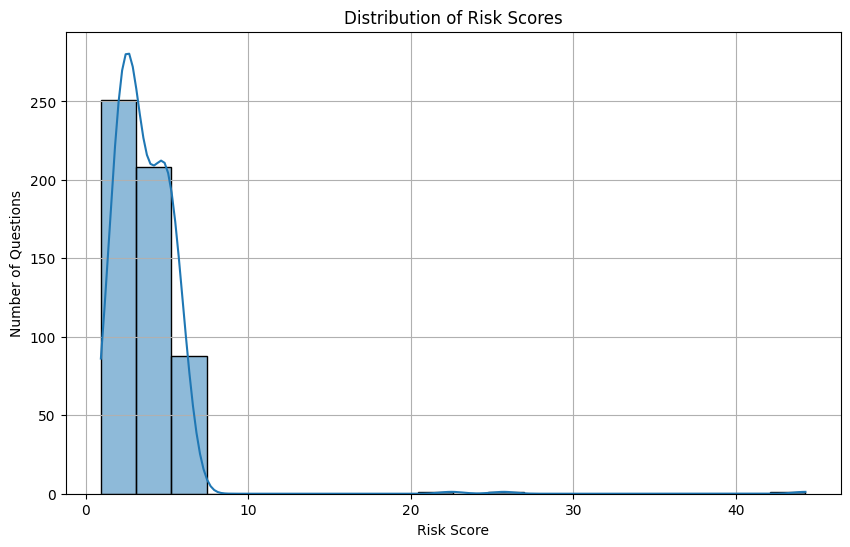

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(df_metrics['risk_score'].dropna(), kde=True, bins=20)
plt.title('Distribution of Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Number of Questions')
plt.grid(True)
plt.show()


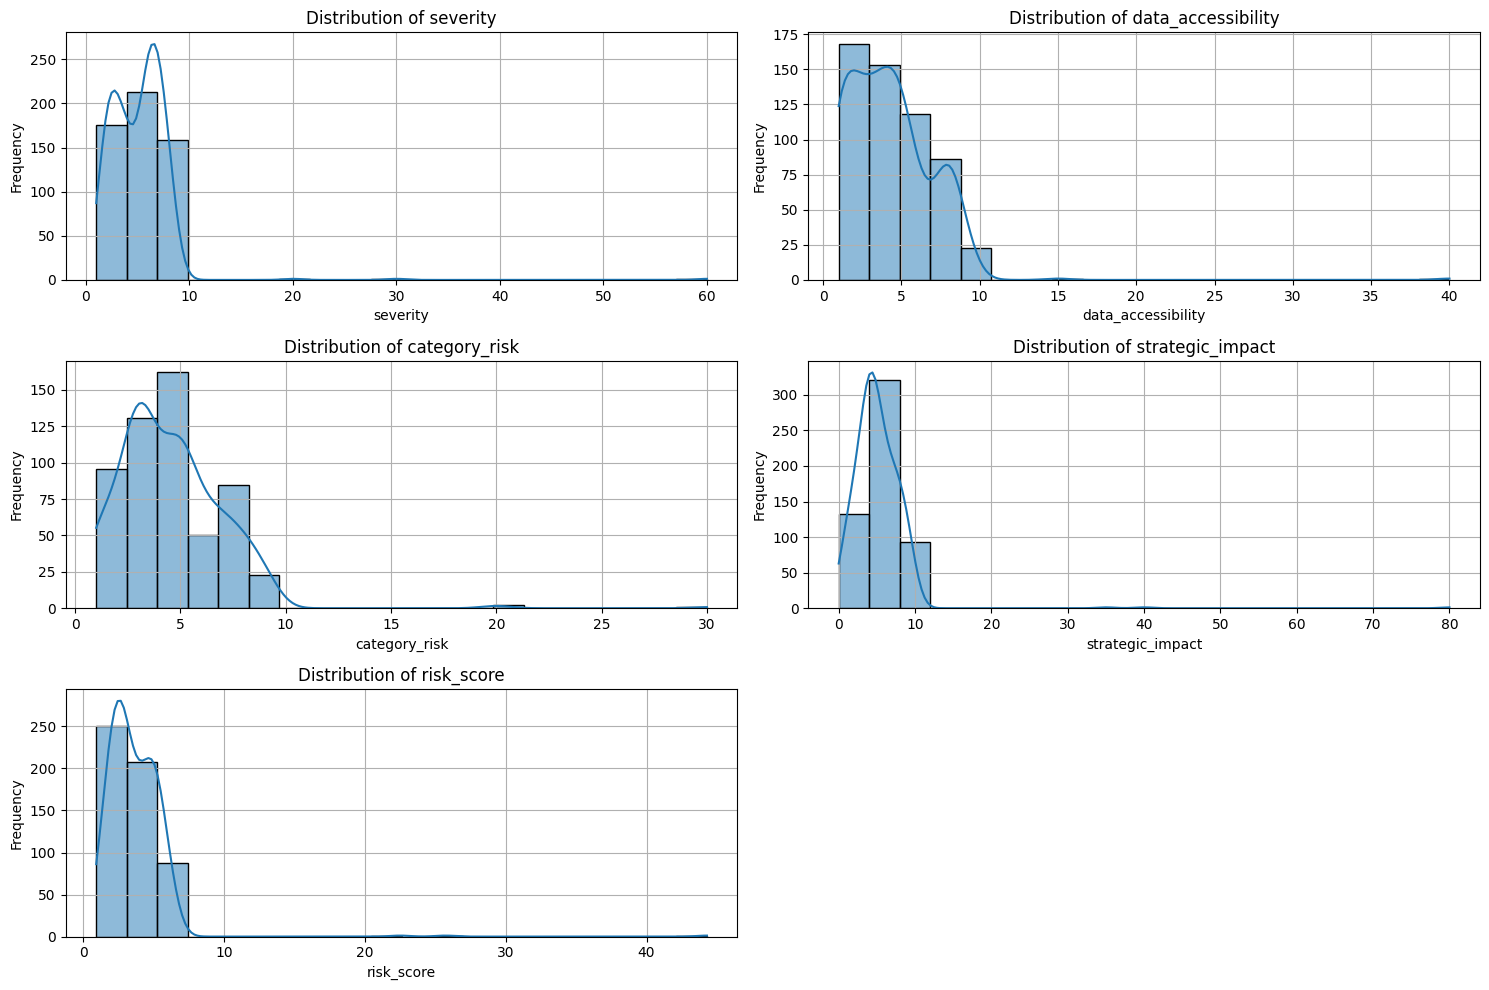

In [9]:
import seaborn as sns

import matplotlib.pyplot as plt

# List of columns to plot
columns_to_plot = ['severity', 'data_accessibility', 'category_risk', 'strategic_impact', 'risk_score']

# Create distribution plots for each column
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df_metrics[column].dropna(), kde=True, bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

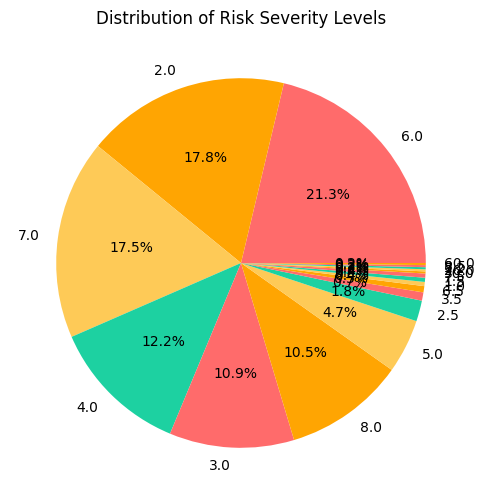

C:\Users\mahmo\AppData\Local\Temp\ipykernel_17680\1374026298.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_metrics, x='severity', order=['Critical', 'High', 'Medium', 'Low'],


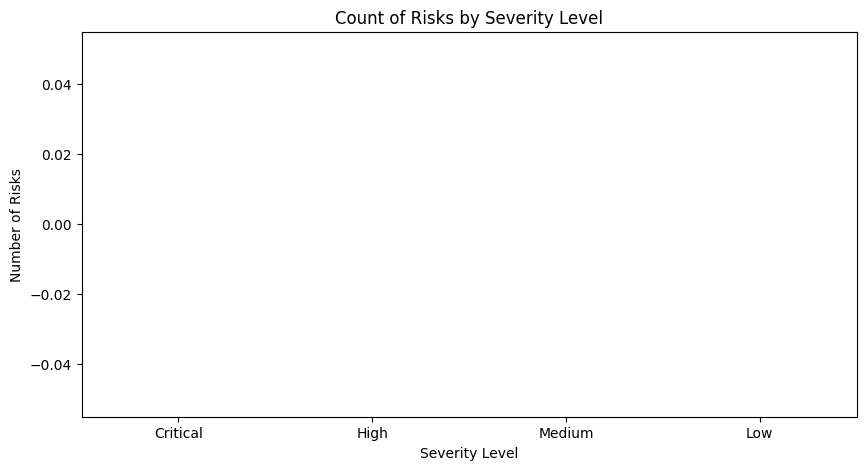

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pie chart for severity distribution
plt.figure(figsize=(8, 6))
severity_counts = df_metrics['severity'].value_counts()
plt.pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%', 
        colors=['#ff6b6b', '#ffa502', '#feca57', '#1dd1a1'])
plt.title('Distribution of Risk Severity Levels')
plt.show()

# Bar chart alternative
plt.figure(figsize=(10, 5))
sns.countplot(data=df_metrics, x='severity', order=['Critical', 'High', 'Medium', 'Low'],
              palette=['#ff6b6b', '#ffa502', '#feca57', '#1dd1a1'])
plt.title('Count of Risks by Severity Level')
plt.xlabel('Severity Level')
plt.ylabel('Number of Risks')
plt.show()

<Figure size 1200x600 with 0 Axes>

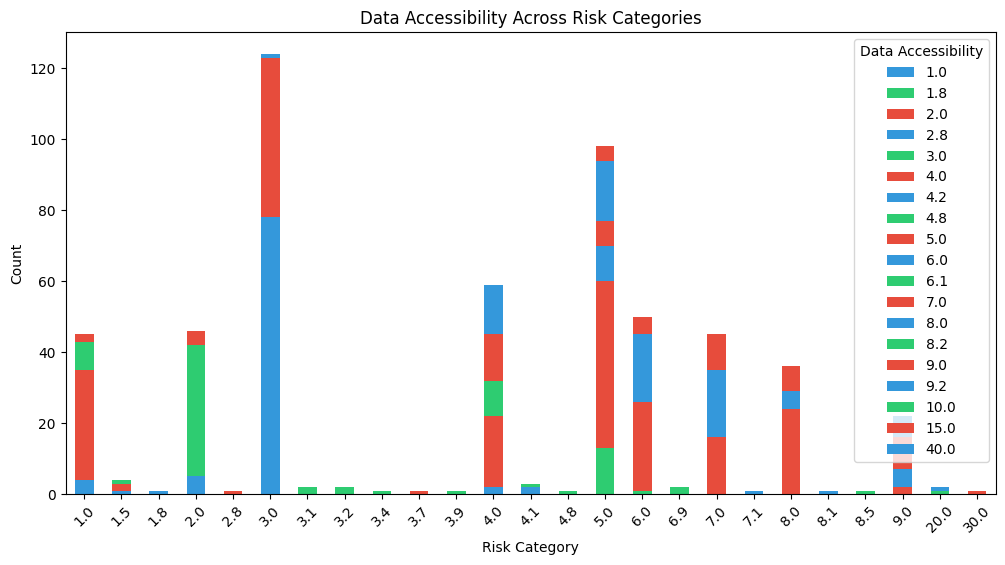

In [11]:
# Stacked bar chart showing data accessibility by category
plt.figure(figsize=(12, 6))
pd.crosstab(df_metrics['category_risk'], df_metrics['data_accessibility']).plot(
    kind='bar', stacked=True, 
    color=['#3498db', '#2ecc71', '#e74c3c'],
    figsize=(12, 6))
plt.title('Data Accessibility Across Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Data Accessibility')
plt.show()

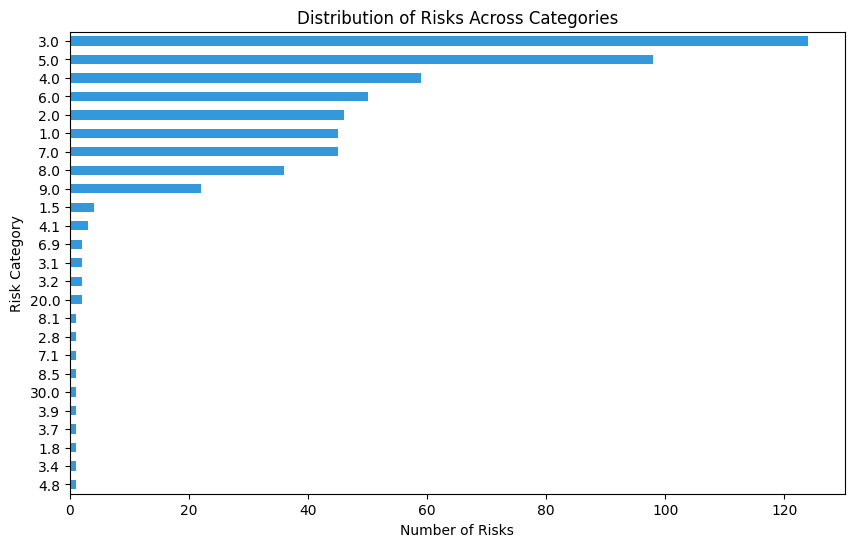

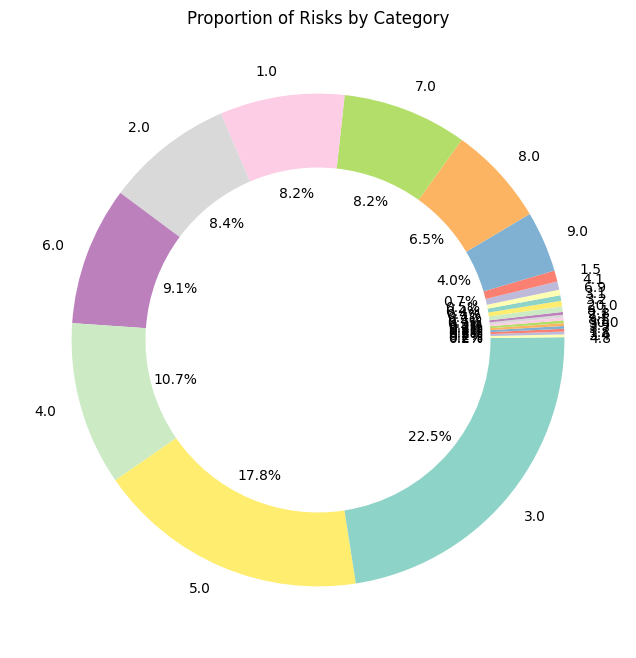

In [13]:
# Horizontal bar chart for risk categories
plt.figure(figsize=(10, 6))
category_counts = df_metrics['category_risk'].value_counts().sort_values()
category_counts.plot(kind='barh', color='#3498db')
plt.title('Distribution of Risks Across Categories')
plt.xlabel('Number of Risks')
plt.ylabel('Risk Category')
plt.show()

# Donut chart alternative
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%',
        wedgeprops=dict(width=0.3), colors=sns.color_palette('Set3'))
plt.title('Proportion of Risks by Category')
plt.show()

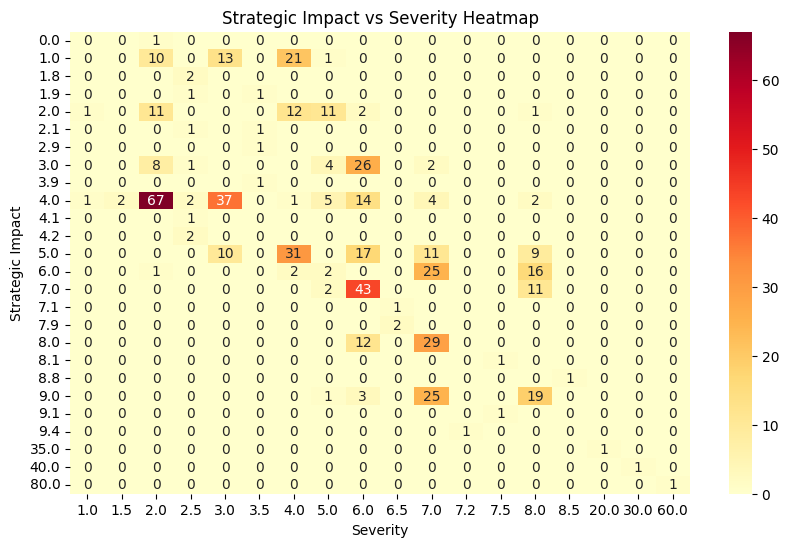

C:\Users\mahmo\AppData\Local\Temp\ipykernel_17680\1142306461.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_metrics, x='strategic_impact', y='risk_score',


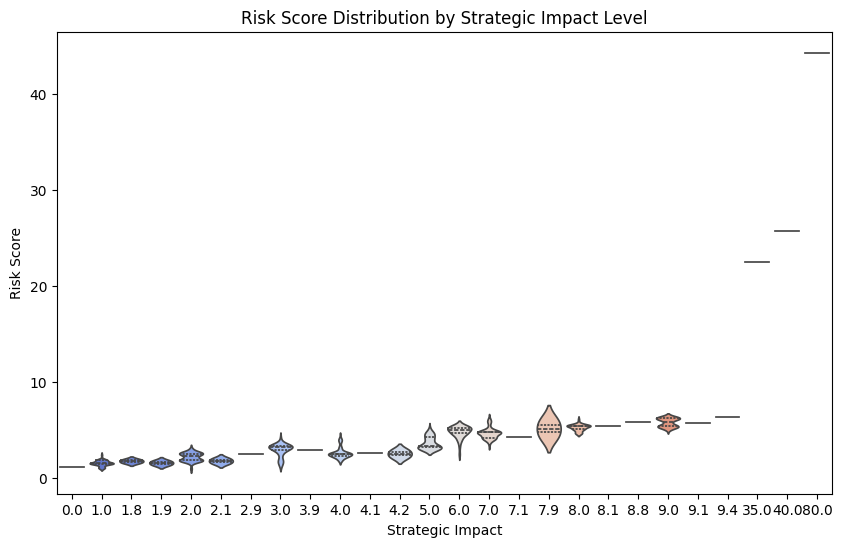

In [16]:
# Heatmap of strategic impact vs severity
plt.figure(figsize=(10, 6))
impact_severity = pd.crosstab(df_metrics['strategic_impact'], df_metrics['severity'])
sns.heatmap(impact_severity, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Strategic Impact vs Severity Heatmap')
plt.xlabel('Severity')
plt.ylabel('Strategic Impact')
plt.show()

# Violin plot showing risk score distribution by strategic impact
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_metrics, x='strategic_impact', y='risk_score', 
               palette='coolwarm', inner='quartile')
plt.title('Risk Score Distribution by Strategic Impact Level')
plt.xlabel('Strategic Impact')
plt.ylabel('Risk Score')
plt.show()

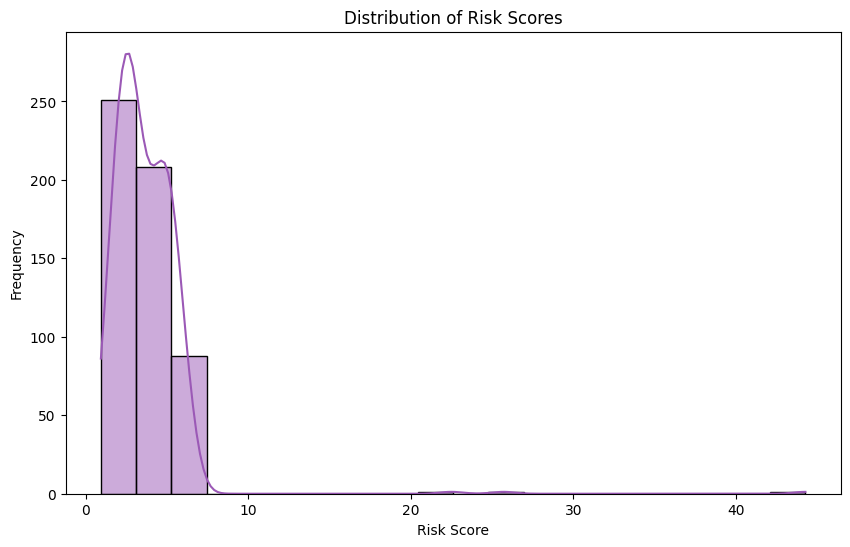

C:\Users\mahmo\AppData\Local\Temp\ipykernel_17680\2547018149.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_metrics, x='category_risk', y='risk_score', palette='Set2')


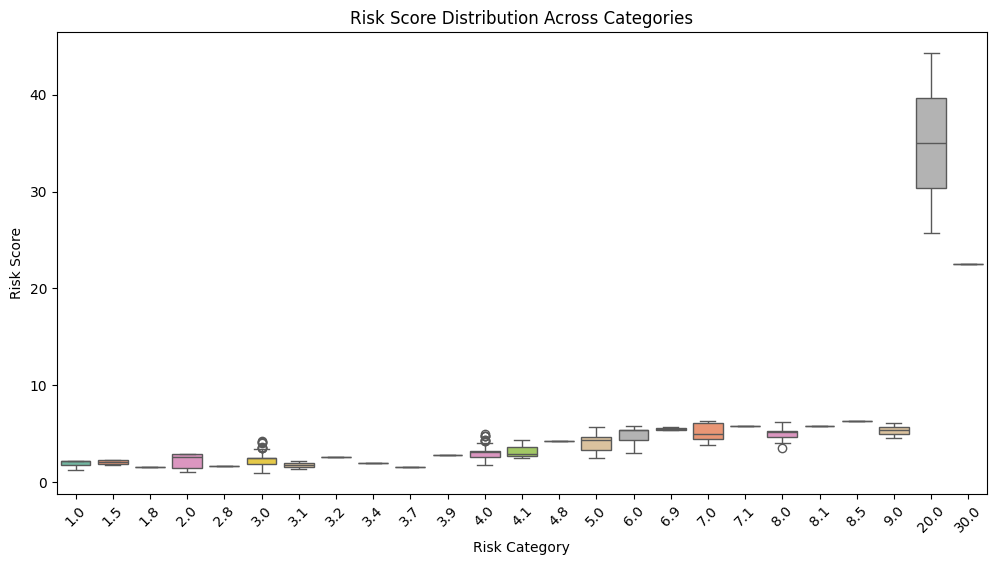

In [18]:
# Histogram and KDE of risk scores
plt.figure(figsize=(10, 6))
sns.histplot(data=df_metrics, x='risk_score', kde=True, bins=20, color='#9b59b6')
plt.title('Distribution of Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.show()

# Boxplot of risk scores by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_metrics, x='category_risk', y='risk_score', palette='Set2')
plt.title('Risk Score Distribution Across Categories')
plt.xlabel('Risk Category')
plt.ylabel('Risk Score')
plt.xticks(rotation=45)
plt.show()

C:\Users\mahmo\AppData\Local\Temp\ipykernel_17680\1500335338.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_metrics, x='category_risk', y='risk_score', ax=axes[0, 1], palette='Set2')
C:\Users\mahmo\AppData\Local\Temp\ipykernel_17680\1500335338.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_metrics, x='strategic_impact', ax=axes[1, 0], palette='coolwarm')


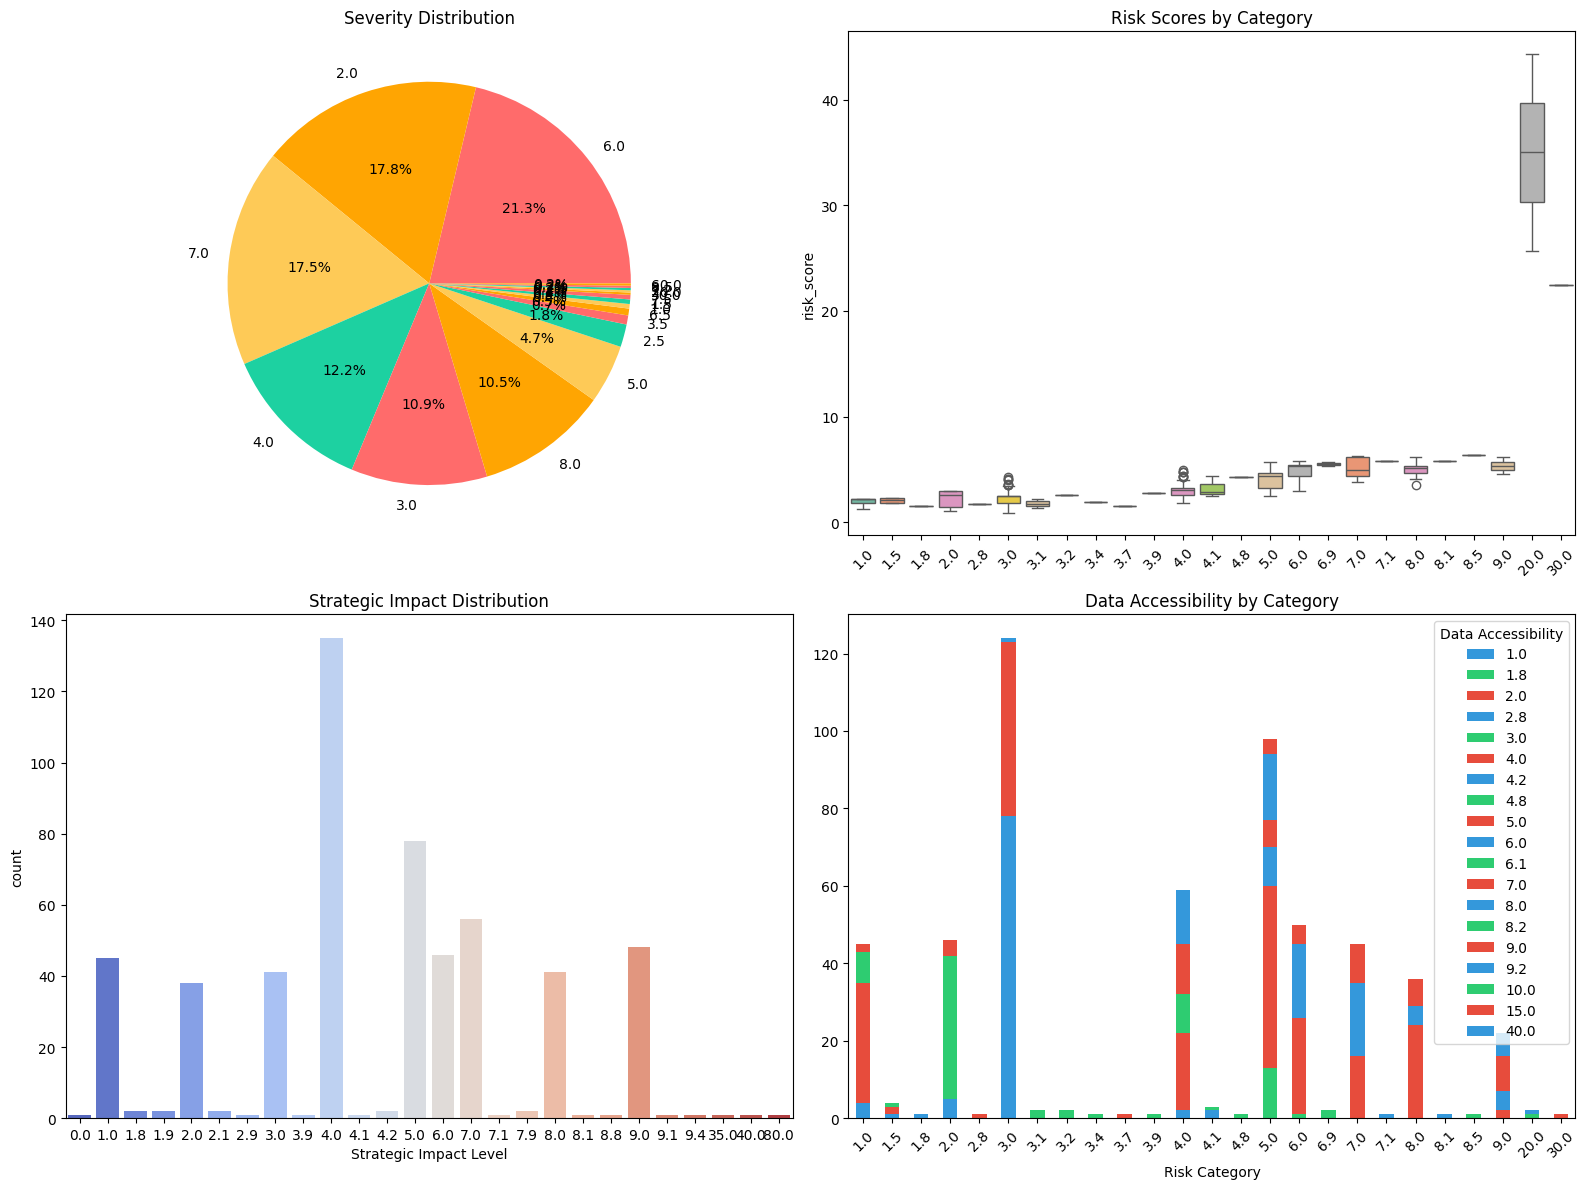

In [19]:
# Create a dashboard with multiple plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top-left: Severity pie chart
severity_counts.plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%', 
                    colors=['#ff6b6b', '#ffa502', '#feca57', '#1dd1a1'])
axes[0, 0].set_title('Severity Distribution')
axes[0, 0].set_ylabel('')

# Top-right: Risk score by category boxplot
sns.boxplot(data=df_metrics, x='category_risk', y='risk_score', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Risk Scores by Category')
axes[0, 1].set_xlabel('')
axes[0, 1].tick_params(axis='x', rotation=45)

# Bottom-left: Strategic impact countplot
sns.countplot(data=df_metrics, x='strategic_impact', ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('Strategic Impact Distribution')
axes[1, 0].set_xlabel('Strategic Impact Level')

# Bottom-right: Data accessibility stacked bar
pd.crosstab(df_metrics['category_risk'], df_metrics['data_accessibility']).plot(
    kind='bar', stacked=True, ax=axes[1, 1], 
    color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1, 1].set_title('Data Accessibility by Category')
axes[1, 1].set_xlabel('Risk Category')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend(title='Data Accessibility')

plt.tight_layout()
plt.show()

C:\Users\mahmo\AppData\Local\Temp\ipykernel_17680\4076229191.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_metrics, x='category', y='severity',
C:\Users\mahmo\AppData\Local\Temp\ipykernel_17680\4076229191.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metrics, x='category', y='severity',
C:\Users\mahmo\AppData\Local\Temp\ipykernel_17680\4076229191.py:9: UserWarning: 
The palette list has fewer values (4) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=df_metrics, x='category', y='severity',
C:\Users\mahmo\AppData\Local\Temp\ipykernel_17680\4076229191.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_metrics, x='category', y='strategic_

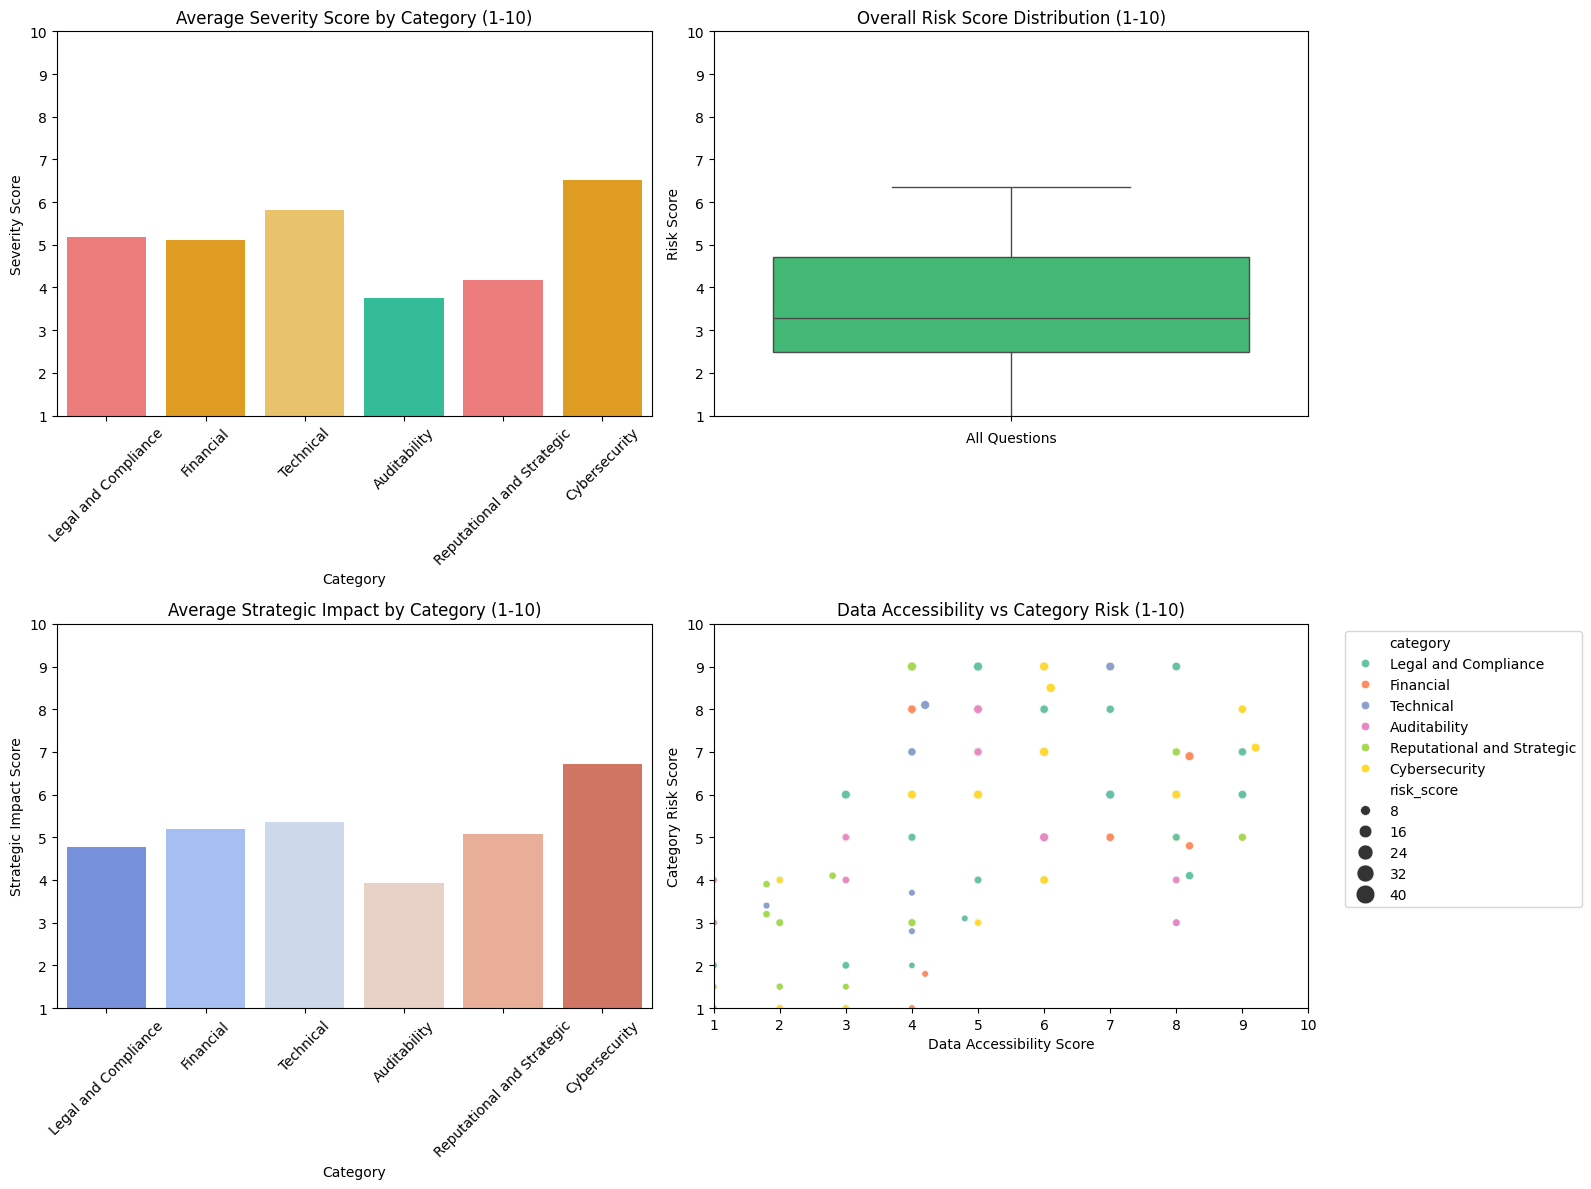

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a dashboard with normalized metrics (1-10 scale)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top-left: Severity Distribution (1-10 scale)
sns.barplot(data=df_metrics, x='category', y='severity', 
            estimator=np.mean, ci=None, ax=axes[0, 0],
            palette=['#ff6b6b', '#ffa502', '#feca57', '#1dd1a1'])
axes[0, 0].set_title('Average Severity Score by Category (1-10)')
axes[0, 0].set_ylim(1, 10)
axes[0, 0].set_xlabel('Category')
axes[0, 0].set_ylabel('Severity Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Top-right: Risk Scores Distribution (1-10 scale)
sns.boxplot(data=df_metrics, y='risk_score', ax=axes[0, 1], color='#2ecc71')
axes[0, 1].set_title('Overall Risk Score Distribution (1-10)')
axes[0, 1].set_ylim(1, 10)
axes[0, 1].set_xlabel('All Questions')
axes[0, 1].set_ylabel('Risk Score')

# 3. Bottom-left: Strategic Impact by Category (1-10 scale)
sns.barplot(data=df_metrics, x='category', y='strategic_impact',
            estimator=np.mean, ci=None, ax=axes[1, 0],
            palette='coolwarm')
axes[1, 0].set_title('Average Strategic Impact by Category (1-10)')
axes[1, 0].set_ylim(1, 10)
axes[1, 0].set_xlabel('Category')
axes[1, 0].set_ylabel('Strategic Impact Score')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Bottom-right: Data Accessibility vs Category Risk (1-10 scales)
sns.scatterplot(data=df_metrics, x='data_accessibility', y='category_risk',
                hue='category', size='risk_score', sizes=(20, 200),
                ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('Data Accessibility vs Category Risk (1-10)')
axes[1, 1].set_xlim(1, 10)
axes[1, 1].set_ylim(1, 10)
axes[1, 1].set_xlabel('Data Accessibility Score')
axes[1, 1].set_ylabel('Category Risk Score')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()